In [13]:
import torch
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

#### Setup llama-3 tokenizer

In [6]:
from llama import Tokenizer
from llama.tokenizer import ChatFormat

tokenizer_path = '/vulcanscratch/psando/llama-3/Meta-Llama-3-8B-Instruct/tokenizer.model'
tokenizer = Tokenizer(model_path=tokenizer_path) # Tokenizing and encoding/decoding text using the Tiktoken tokenizer.
formatter = ChatFormat(tokenizer)                # For 

In [11]:
test_str = "This is a test sentence."
test_str_message = {"role": "user", "content": test_str}

tokenizer_tokens = tokenizer.encode(test_str, bos=True, eos=True)
formatter_tokens = formatter.encode_message(test_str_message)
print(f'Tokenizer tokens: {tokenizer_tokens}\n\tLen: {len(tokenizer_tokens)}')
print(f'Formatter tokens: {formatter_tokens}\n\tLen: {len(formatter_tokens)}')

Tokenizer tokens: [128000, 2028, 374, 264, 1296, 11914, 13, 128001]
	Len: 8
Formatter tokens: [128006, 882, 128007, 271, 2028, 374, 264, 1296, 11914, 13, 128009]
	Len: 11


In [31]:
tokenizer.decode([271])

'\n\n'

In [32]:
tokenizer.encode("\n\n", bos=True, eos=True)

[128000, 271, 128001]

#### Set up datacomp recaptioned

In [36]:
# contains 00028118.tar and output_28118.pkl
datacomp_recaptioned_dir = Path('/fs/vulcan-projects/stereo-detection/datacomp_recaptioned_shard')

# open the pickle file, which contains a list of dictionaries
# each dictionary contains the original image json plus 'vlm_model' and 'vlm_caption' keys
with open(datacomp_recaptioned_dir / 'output_28118.pkl', 'rb') as f:
    data = pickle.load(f)

# print data stats
print('Number of dicts:', len(data))

# Helper fn
def plot_datacomp_recap_sample(key):
    # Plot the image, the original caption and the new caption
    for d in data:
        if d['key'] == key:
            img = plt.imread(datacomp_recaptioned_dir / '00028118' / f'{key}.jpg')
            plt.imshow(img)
            plt.axis('off')
            print('Original caption:', d['caption'])
            print('VLM model caption:', d['vlm_caption'])
            plt.show()
            break

Number of dicts: 8154


Min caption length: 5
Min caption: {'key': '000281189902', 'caption': '', 'tokens': [128006, 882, 128007, 271, 128009]}
Max caption length: 1976
Max caption: {'key': '000281189792', 'caption': ' This image displays:\n\nA sleeveless, fitted, floor-length dress with a dropped waist and a flared trumpet skirt. The dress is a dark blue color. The dress has a high crew neck. The image is a photograph taken from a slightly elevated angle, and the dress is displayed on a dress form with no head or arms. The dress form is standing between a tan background and a grey background, and the dress form and the dress are both centered within the image.', 'tokens': [128006, 882, 128007, 271, 2028, 2217, 19207, 1473, 32, 37253, 1752, 11, 29441, 11, 6558, 30425, 8679, 449, 264, 12504, 29142, 323, 264, 1344, 1636, 92359, 38380, 13, 578, 8679, 374, 264, 6453, 6437, 1933, 13, 578, 8679, 706, 264, 1579, 13941, 13272, 13, 578, 2217, 374, 264, 10512, 4529, 505, 264, 10284, 32389, 9392, 11, 323, 279, 8679, 374

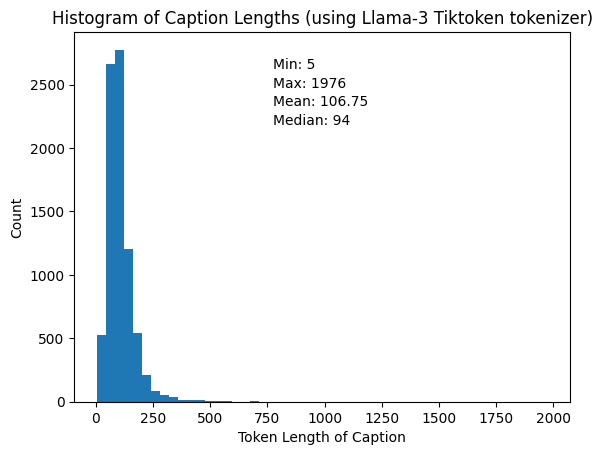

In [34]:
# Plot a histogram of formatter tokens
# For each data dictionary, we get the 'vlm_caption' key and encode it using the formatter
# We print the min, max, mean, and median lengths of the encoded captions

caption_lengths = []
min_caption_example = None
max_caption_example = None
for d in data:
    caption = d['vlm_caption']
    message = {"role": "user", "content": caption}
    caption_tokens = formatter.encode_message(message)
    caption_lengths.append(len(caption_tokens))

    if len(caption_tokens) == 5:
        min_caption_example = {'key': d['key'], 'caption': caption, 'tokens': caption_tokens}
    elif len(caption_tokens) == 100:
        max_caption_example = {'key': d['key'], 'caption': caption, 'tokens': caption_tokens}

caption_lengths = np.array(caption_lengths)
# Plot these stats in the image as text
plt.text(0.4, 0.9, f'Min: {caption_lengths.min()}', transform=plt.gca().transAxes)
plt.text(0.4, 0.85, f'Max: {caption_lengths.max()}', transform=plt.gca().transAxes)
plt.text(0.4, 0.8, f'Mean: {caption_lengths.mean():0.2f}', transform=plt.gca().transAxes)
plt.text(0.4, 0.75, f'Median: {int(np.median(caption_lengths))}', transform=plt.gca().transAxes)

plt.hist(caption_lengths, bins=50)
plt.xlabel('Token Length of Caption')
plt.ylabel('Count')
plt.title('Histogram of Caption Lengths (using Llama-3 Tiktoken tokenizer)')

# Print exemplary captions
print(f'Min caption length: {caption_lengths.min()}')
print(f'Min caption: {min_caption_example}')
print(f'Max caption length: {caption_lengths.max()}')
print(f'Max caption: {max_caption_example}')


Original caption: Full Frame Shot Of Luxury Leather Furniture
VLM model caption: 


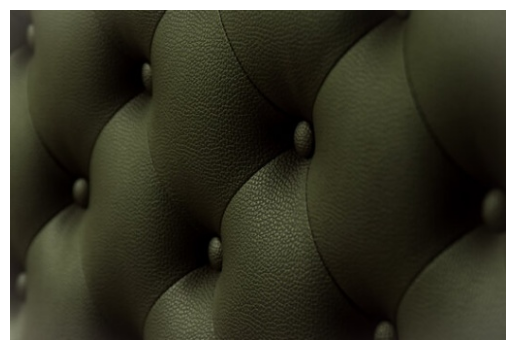

Original caption: Before Midnight Gown by BCBGMAXAZRIA
VLM model caption:  This image displays:

A sleeveless, fitted, floor-length dress with a dropped waist and a flared trumpet skirt. The dress is a dark blue color. The dress has a high crew neck. The image is a photograph taken from a slightly elevated angle, and the dress is displayed on a dress form with no head or arms. The dress form is standing between a tan background and a grey background, and the dress form and the dress are both centered within the image.


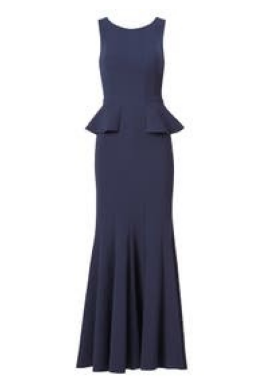

In [37]:
plot_datacomp_recap_sample('000281189902') # Shortest token seq image
plot_datacomp_recap_sample('000281189792') # Longest token seq image